# Table of Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Simple Statistics](#Simple-Statistics)
4. [Depth of the Category Heirarchy](#Depth-of-the-Category-Heirarchy)
5. [Searching the Catalog](#Searching-the-Catalog)
6. [Lengths of the Time Series](#Lengths-of-the-Time-Series)
   * [The Problem of Merry Olde England](#The-Problem-of-Merry-Olde-England)
   * [Most Common Sampling Rates](#Most-Common-Sampling-Rates)
   * [Distribution of Series Lengths](#Distribution-of-Series-Lengths)

# Introduction

This notebook is a brief introduction to the [FRED][1] catalog.

What is FRED? [As per the FRED website][2],
>Short for Federal Reserve Economic Data, FRED is an online database consisting of hundreds of thousands of economic data time series from scores of national, international, public, and private sources. FRED, created and maintained by the Research Department at the Federal Reserve Bank of St. Louis, goes far beyond simply providing data: It combines data with a powerful mix of tools that help the user understand, interact with, display, and disseminate the data. In essence, FRED helps users tell their data stories. The purpose of this article is to guide the potential (or current) FRED user through the various aspects and tools of the database.

The FRED database is an abolute gold mine of economic data time series. Thousands of such series are published on the FRED website, [organized by category][3] and avialable for viewing and downloading. In fact, a number of these economic datasets have been uploaded to kaggle. With in the current notebook, however, we ***are not*** interested in the individual time series; rather, we are focused on catalog itself.

The [FRED API][4] has been used for gaining access to the catalog.  The catalog consists of two files
* `categories.csv` - the heirarchy of categories used for organizing the time series
* `series.csv` - the list of avialable time series themselves

A given category is identified by a `category_id`.  And, in a similar fashion, a given series is identified by a `series_id`.  In a given category, one may find both a group of series and a set of sub-categories. As such every
* series record contains a `category_id` to identify the immediate category under which it is found
* category record contains a `parent_id` to indicate where in the category heirarchy it resides

As this notebook represents the introduction to the FRED Catalog dataset, we would like to affirm our adherence to the [terms of use][5] required by applications using the FRED API. In particular, we need state that while ***this product used the FRED® API but is not endorsed or certified by the Federal Reserve Bank of St. Louis.***

[1]:https://fred.stlouisfed.org/
[2]:https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/
[3]:https://fred.stlouisfed.org/categories
[4]:https://fred.stlouisfed.org/docs/api/fred/
[5]:https://fred.stlouisfed.org/docs/api/terms_of_use.html

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
CATEGORIES = '/kaggle/input/fred-economic-data-catalog/categories.csv'
SERIES = '/kaggle/input/fred-economic-data-catalog/series.csv'
df_categories = pd.read_csv(CATEGORIES)
df_series = pd.read_csv(SERIES)

# Simple Statistics
We will start by putting together a few basic statistics about the catalog.

In [2]:
nc_size = len(df_categories)
nc_count = df_categories.category_id.nunique()
nc_child = df_categories.parent_id.nunique()
nc_series = df_series.category_id.nunique()

has_child = df_categories.category_id.isin( df_categories.parent_id)
has_series =  df_categories.category_id.isin( df_series.category_id)

nc_child_no_series = df_categories[ has_child & ~has_series].category_id.nunique()
nc_series_no_child = df_categories[ ~has_child & has_series].category_id.nunique()
nc_child_and_series = df_categories[ has_child & has_series].category_id.nunique()
nc_empty = df_categories[ ~has_child & ~has_series].category_id.nunique()

ns_size = len(df_series)
ns_count = df_series.series_id.nunique()
ns_multi_category = len( df_series.series_id.value_counts().reset_index(name='counts').query('counts>1'))
ns_orphan = df_series[ ~df_series.category_id.isin( df_categories.category_id) ].category_id.nunique()

statistic = lambda x,y,z: { 'type' : x, 'stat' : y, 'value' : z }
pd.DataFrame([
    statistic('category', 'table size', nc_size),
    statistic('category', 'unique', nc_count ),
    statistic('category', 'having subcategories', nc_child),
    statistic('category', 'having series', nc_series),
    statistic('category', 'having both series and subcategores', nc_child_and_series),
    statistic('category', 'having only series', nc_series_no_child),
    statistic('category', 'having only subcategories', nc_child_no_series),
    statistic('category', 'empty', nc_empty ),
    statistic('series', 'table size', ns_size),
    statistic('series', 'unique', ns_count),
    statistic('series', 'found in multiple categories', ns_multi_category),
    statistic('series', 'orphaned (category_id not in catalog)', ns_orphan),
    ])

,type,stat,value
0,category,table size,5183
1,category,unique,5183
2,category,having subcategories,385
3,category,having series,4839
4,category,having both series and subcategores,119
5,category,having only series,4720
6,category,having only subcategories,266
7,category,empty,78
8,series,table size,708788
9,series,unique,647004


With the category table, we see that each row represents a unique category - there are no duplicate `category_id` present. Relatively few of the categories are divided into subcategories ( $385 / 5183 \approx 7.5\%$), but the vast majority ( $4839/5183 \approx 94.4\%$) hold series. This would seem to imply that the vast majority of the series are found in leaf nodes of the categories tree. The pie graph below, displaying the type of content found in the various categories, emphasizes this point, showing that
* the vast majority of the categories leaf nodes (lacking subcategories)
* the vast majority of the leaf nodes contain series (very few are empty)
* the majority ($\approx 70\%$) of the internal nodes (nodes with subcategories) are there simply for "organizational" reasons - they hold subcategories but no time series. 



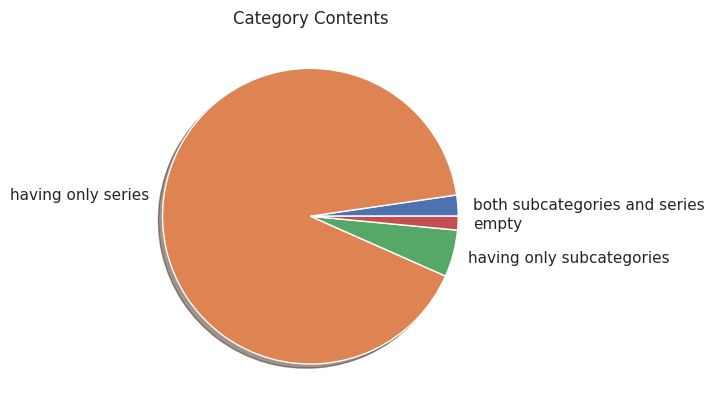

In [3]:
sizes = [nc_child_and_series, nc_series_no_child, nc_child_no_series, nc_empty]
labels = ['both subcategories and series', 'having only series', 'having only subcategories', 'empty']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, shadow=True, startangle=0)
plt.title( 'Category Contents');

The series statistics are interesting. The FRED contains a ***huge*** number of time series - almost 650,000!  Luckily, there are no "orphaned" series; the `category_id` cited in the each and every series record can be found in the categories table. On the other hand, a fair fraction of the series ($\approx 9\%$) are housed under ***multiple*** categories.

For these series residing in multiple categories, how are they distributed?  For example, are they typically found in two categories? In three? In the graph below, we have extracted thiese multi-homed series and simply counted the number of categores in which they reside. The vast marjority ($\approx 95.5\%$) are seen to live in just two categores, and most of the rest ($\approx 4.4\%$) are found in either two or three categories. There were a smidgeon that were found in more than four categories - with the most extreme case being 6 series that were found living under 8 distinct categories!

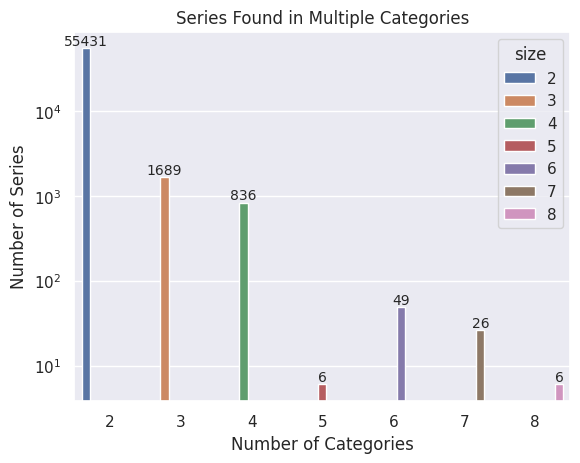

In [4]:
_ = df_series.groupby('series_id', as_index=False).size().query('size>1')['size'].value_counts()
ax = sns.barplot(x=_.index, y=_.values, hue=_.index)
plt.yscale('log')
plt.xlabel("Number of Categories")
plt.ylabel("Number of Series")
plt.title("Series Found in Multiple Categories")
for container, label in zip( ax.containers, _ ):
    ax.bar_label(container, label=label, fontsize=10);

# Depth of the Category Heirarchy

As mentioned in the introduction, the categories into which the time series are placed are themselves organized into a heirarchy - which basically means that the categories form a tree structure. The top of this heirarchy is a root node which is assigned a `category_id`=0. The highest level categories lie just below the root, and are as follows:

In [5]:
df_categories.query( 'parent_id==0')

,category_id,name,parent_id,notes
0,0,Categories,0,NaN
1,1,Production & Business Activity,0,NaN
2,10,"Population, Employment, & Labor Markets",0,NaN
3,3008,U.S. Regional Data,0,NaN
4,32263,International Data,0,NaN
5,32455,Prices,0,NaN
6,32991,"Money, Banking, & Finance",0,NaN
7,32992,National Accounts,0,NaN
8,33060,Academic Data,0,NaN


How deep is this heirarchy?  How many categories are found at the highest level? At the second highest level? And so on?  To answer this, we would like to add an attribute to a category record which provides the depth of the given category in the heirarchy.

Finding the depth of a given node is basically a recursive job, where
* the root node has a depth of 0
* the children of the root node have a depth of 1
* the children of the children have a depth of 2
* and so on

In the following, we will use this recursive approach to construct a dictionary, mapping a `category_id` to the depth of the level, then use this to add the `depth` as an attribute of the category record.

In [6]:
# ###############################################
# Create a map, keyed  by "parent_id", of the
# children belonging to said parent
# ###############################################
children = df_categories.query('category_id != 0').\
    groupby('parent_id').\
    category_id.unique().\
    to_dict()

# ###############################################
# Calculate the depth of each node
# ###############################################
root_node = 0
depth = { root_node : 0}

def assign_depth_to_children( parent_id, level):
    if parent_id not in children:
        return
    for child_id in children[parent_id]:
        depth[child_id] = level
        assign_depth_to_children( child_id, level + 1)
assign_depth_to_children( root_node, 1)

# ###############################################
# And... add it into the dataset as an attribute
# ###############################################
df_categories['depth'] = df_categories.category_id.map( depth )

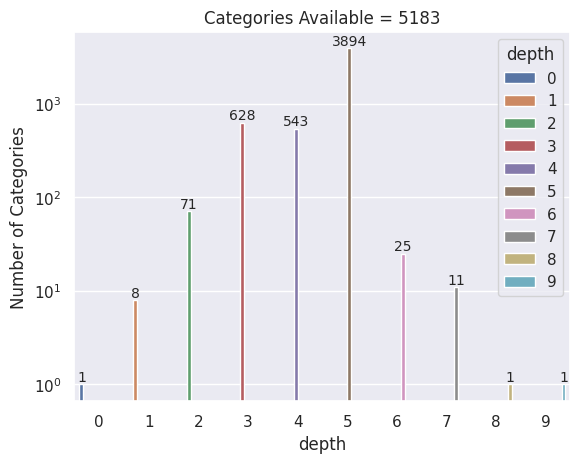

In [7]:
_ = df_categories.depth.value_counts().sort_index()
ax = sns.barplot(x=_.index, y=_.values, hue=_.index)
plt.ylabel("Number of Categories")
plt.yscale('log')
plt.title(f"Categories Available = {len(df_categories)}")
for container, label in zip( ax.containers, _ ):
    ax.bar_label(container, label=label, fontsize=10);

As one can see
* the catalog has 8 tier 1 (depth=1) categories sitting directly under the root
* underneath that are 71 tier 2 categories
* the bulk of the categories lie fairly deep in the tree, at a depth of 5
* the are even a couple of categories that are extraordinarly deep - appearing at a depth of 8 and 9

Note that due to the concentration of categtories at depths of 3, 4, and 5, we needed to use a log scale when plotting the data to be able to see the other counts at the other depths.

# Searching the Catalog
<img src="https://www.freeworldmaps.net/united-states/oregon/oregon-map.jpg" align="right" style="height:300px"/>

One of our primary motivations for downloading the FRED catalog was the fact that we found the online search utilities to be quite clumsy. We are a huge fan of [grep][1] and typically find that the more one wraps the bangles and baubles of GUIs around the basic grep functionality, the worst the experience!

That being said, let's work through an example of trying to search the catalog. As we are from [the Great State of Oregon][2], we would like to see what type of time series can be found in the FRED catalog covering Oregon.  We will start by simply searching the series table for titles containing the word **Oregon**.

[1]:https://en.wikipedia.org/wiki/Grep
[2]:https://en.wikipedia.org/wiki/Oregon

In [8]:
df_series[ df_series.title.str.lower().str.contains('oregon')].title.unique()[:10]

array(['Business Applications: Total for All NAICS in Oregon',
       'Business Applications from Corporations: Total for All NAICS in Oregon',
       'High-Propensity Business Applications: Total for All NAICS in Oregon',
       'Business Applications with Planned Wages: Total for All NAICS in Oregon',
       'Business Formations Within 4 Quarters for Oregon (DISCONTINUED)',
       'Business Formations within 8 Quarters for Oregon (DISCONTINUED)',
       'Business Formations Within Four Quarters: Total for All NAICS in Oregon',
       'Labor Productivity for Private Nonfarm in Oregon',
       'Hours Worked for Private Nonfarm in Oregon',
       'Labor Compensation for Private Nonfarm in Oregon'], dtype=object)

The phrase **private nonfarm** caught our eye here. Apparently, this is a [common economic classification][1] which means
>Private Nonfarm Payrolls measures the change in the number of total payrolls in any business, excluding general government employees, private household employees, employees of nonprofit organizations that provide assistance to individuals and farm employees.

For now, let's focus on the series ***Hours Worked for Private Nonfarm in Oregon***.  Where would we find this series?

[1]:https://tradingeconomics.com/united-states/nonfarm-payrolls-private

In [9]:
title = 'Hours Worked for Private Nonfarm in Oregon'
df_series.query(f'title=="{title}"').category_id.unique()

array([32351, 27319])

The series is housed in two different categories. Honestly, though, simply knowing the `category_id` as it is a bit too abstract. To get a better insight into where the in the catalog the series resides, let's build a simple utility that traverses the category heirarchy tracing out the categories and subcategories one needs to descend to find the series.

In [10]:
def ancestors( category_id ):
    ROOT = 0
    _ = df_categories[ df_categories.category_id == category_id]
    if len(_) == 0:
        return f'ERROR - unknown category_id {category_id}'
    
    if category_id == ROOT:
        return _
    else:
        parent_id = _.iloc[0].parent_id
        return pd.concat( [ancestors( parent_id), _]).reset_index(drop=True)
        

With this utility in hand, where do we find the series ***Hours Worked for Private Nonfarm in Oregon***?

In [11]:
ancestors(27319)

,category_id,name,parent_id,notes,depth
0,0,Categories,0,NaN,0
1,3008,U.S. Regional Data,0,NaN,1
2,27281,States,3008,NaN,2
3,27319,Oregon,27281,NaN,3


In [12]:
ancestors(32351)

,category_id,name,parent_id,notes,depth
0,0,Categories,0,NaN,0
1,10,"Population, Employment, & Labor Markets",0,NaN,1
2,2,Productivity & Costs,10,NaN,2
3,32351,Nonfarm Business,2,NaN,3


This makes perfect sense!  As we searched for the term **oregon**, the series was naturally found in a category dedicated to the State of Oregon.  And, since the series we selected targeted **nonfarm business**, we see that the particular time series was also found in a category dedicated to Nonfarm Business.

# Lengths of the Time Series
In this section, we want to look at the distribution of the lengths of the time series pubished on the FRED. While this may seem like a rather random and odd thing to do, it actually goes towards the very thing that attracted us to this dataset: the [FRED][1] is a wonderfully rich playground that can be used to explore time series techniques, such as those described by [Rob J Hyndman][2] and [George Athanasopoulos][3] in their book [Forecasting: Principles and Practice][4].  With that as a motivation, it may make sense to try to build up a toolkit to serach for time series "of sufficient length."

While the series records in the FRED catalog do not ***directly*** indicate their length, they do provide server attributes which can be used to to infer the length
* `observation_start` - a date formatted as YYYY-MM-DD
* `observation_end` - a date, formatted as YYYY-MM-DD
* `frequency` - indicating the period of observation

Knowing the duration of the dataset (the time between the **start** and **end** of observations) and the sampling frequency should be sufficient to let one calculated the expected number of observations in the given time series.  And that is the approach we shall take here.

## The Problem of Merry Olde England
We ***thought*** that this exercise would be litte more than a trivial application of the fantastic [timeseries support][5] provided out-of-the-box with [pandas][6]. To our surprise, this [led us down a rabbit hole][7] associated with Merry Olde England.

When trying to perform this calculation, a problem rears its ugly head almost immediately.  The standard approach to calculating the time span covered by series would be to use `pd.to_datetime` to convert the first and last dates of the time series a timestamp, and then diff the results. Unfortunately, running `pd.to_datetime( df_series.observation_start)` throws a rather unusual exception.

The problem stems from the fact that the pandas Datetime support is highly focused on representing Timestamps as nanoseconds since the epoch.  This imposes a [limitation][8] that it cannot represent dates prior to 1677-09-21. One could be forgiven for believing that such a limitation is not much of a practical constraint.  Nonetheless, we found that there were 10 series in the FRED catalog whose `observation_start` preceded this date. Furthoremore, all of these ancient datasets lay under a category entitled **A Millennium of Macroeconomic Data for the UK**.

[1]:https://fred.stlouisfed.org/
[2]:https://robjhyndman.com/
[3]:https://research.monash.edu/en/persons/george-athanasopoulos
[4]:https://otexts.com/fpp3/
[5]:https://pandas.pydata.org/docs/user_guide/timeseries.html
[6]:https://pandas.pydata.org/
[7]:https://en.wikipedia.org/wiki/Down_the_rabbit_hole
[8]:https://pandas.pydata.org/docs/user_guide/timeseries.html#timestamp-limitations

In [13]:
OLDEST_SUPPORTED_DATE = str( pd.Timestamp.min.date() )

_ = df_series.query( f'observation_start < "{OLDEST_SUPPORTED_DATE}"')
print(f"{_.series_id.nunique()} were found starting before {OLDEST_SUPPORTED_DATE}." )
print("These series are found under the following categories:")
for category_id in _.category_id.unique():
    display( ancestors( category_id) )

10 were found starting before 1677-09-21.
These series are found under the following categories:


,category_id,name,parent_id,notes,depth
0,0,Categories,0,NaN,0
1,33060,Academic Data,0,NaN,1
2,33839,A Millennium of Macroeconomic Data for the UK,33060,NaN,2
3,33843,"Labour, Capital and Productivity",33839,NaN,3


,category_id,name,parent_id,notes,depth
0,0,Categories,0,NaN,0
1,33060,Academic Data,0,NaN,1
2,33839,A Millennium of Macroeconomic Data for the UK,33060,NaN,2
3,33845,National Accounts,33839,NaN,3


,category_id,name,parent_id,notes,depth
0,0,Categories,0,NaN,0
1,33060,Academic Data,0,NaN,1
2,33839,A Millennium of Macroeconomic Data for the UK,33060,NaN,2
3,33847,Wages and Prices,33839,NaN,3


Unfortunately, simply throwing out these 10 series does not fully address the problem. The pandas datetime support does not easily support time differences that exceed the maximum value of a signed long (`Long.MAX_VALUE=0x7FFFFFFFFFFFFFFF`). It turns out that the date 1677-09-21 corresponds to `Long.MAX_VALUE` nanoseconds prior to the [start of Unix epoch][1] 1970-01-01.  As of now (2025-03-30), 75 years have passed since the beginning of the Unix epoch. This means that there si an additional 75 years worth of `observation_start` dates the we would most likely need to throw away to avoid problems with calculating time differences.

The underlying problem here lies with mandating that datetimes are represented in terms of ***nanoseconds*** since the epoch. While the pandas timeseries support is fairly insistent upon using nanoseconds, the underlying [numpy datetime64][2] implementation does not demand this. While the numpy.datetime64 does use a long to represent the date, it offers the user the ability to specify how to interpret that long by specifying an approprorate [datetime-unit][3].  While nanoseconds are the default datetime-unit, one could expand the expand the available time span by a factor of a billion by simply using a datetime-unit of 's'=***seconds*** rather than relying on the default value of ***nanoseconds***. 

While the [pandas.Timestamp][4] class also allows one to configure its internal representation of a timestamp via this datetime-unit feature, this flexibility is not actually exposed to users of [pandas.to_datetime][5]. In addition, when trying to calculate the durations of the time series, we repeatedly ran into situations where pandas timeseries manipulations "tried to be friendly" by times and timedeltas to nanoseconds. As such, we found that the easiest way to calculate durations was to pull the entire calculation outside of pandas and only use pandas for recording the final timedeltas.

[1]:https://en.wikipedia.org/wiki/Unix_time
[2]:https://numpy.org/doc/stable/reference/arrays.datetime.html
[3]:https://numpy.org/doc/stable/reference/arrays.datetime.html#datetime-units
[4]:https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html
[5]:https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [14]:
to_datetime = lambda x : x.to_numpy().astype('datetime64[s]')
df_series['duration'] = to_datetime( df_series.observation_end) - to_datetime( df_series.observation_start)

## Most Common Sampling Rates
It turns out that the FRED datasets employ a wide variety of sampling frequencies.  However, most of the sample rates are only rarely employeed. When we turn to calculting the lengths of the datasets in the next section, we would like to focus on just the most commonly used sampling frequecies in order to reduce the noise. 

As seen below, the top 3 frequencies - **Annual**, **Monthly**, and **Quarterly** - account for over 97% of the series.

In [15]:
df_unique_series = df_series.drop_duplicates(subset='series_id').reset_index(drop=True)
_ = df_unique_series.frequency.value_counts().to_frame(name='counts').reset_index()
_['fraction'] = ( _.counts / _.counts.sum()).map( "{:.2%}".format)
_['cumulative fraction'] = ( _.counts.cumsum() / _.counts.sum()).map( "{:.2%}".format)

print(f"{len(_)} sampling frequecies seen, the top 10 of which are")
_.head(10)

42 sampling frequecies seen, the top 10 of which are


,frequency,counts,fraction,cumulative fraction
0,Annual,401994,62.13%,62.13%
1,Monthly,172167,26.61%,88.74%
2,Quarterly,57869,8.94%,97.69%
3,"Quarterly, 2nd Month's 1st Full Week",2424,0.37%,98.06%
4,Semiannual,1817,0.28%,98.34%
5,"Quarterly, End of Quarter",1151,0.18%,98.52%
6,"Quarterly, End of Period",1143,0.18%,98.70%
7,"Daily, 7-Day",1076,0.17%,98.86%
8,"Annual, End of Period",1070,0.17%,99.03%
9,"Weekly, As of Wednesday",1052,0.16%,99.19%


## Distribution of Series Lengths
Finally, we are in a position to calculate both the length of an individual series and the distribution of lengths for a given sampling frequency. Our tool of choice for presenting a probability distribution is the [Cumulative Distribution Function (CDF)][1], both for the simplicity of calculation and the ease of interpretation. 

[1]:https://en.wikipedia.org/wiki/Cumulative_distribution_function

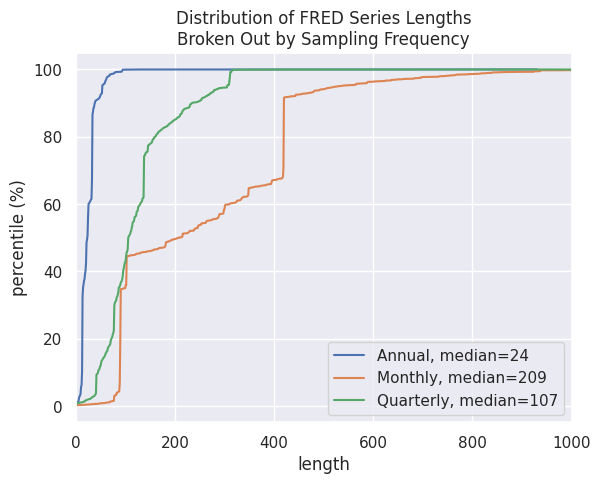

In [16]:
common = ['Annual', 'Monthly', 'Quarterly']
cols = ['series_id', 'frequency','duration']
fig, ax = plt.subplots( facecolor='white')
df = df_unique_series.query(f'frequency.isin({common})')[cols]
unit = {
    'Annual' : 365.25,
    'Quarterly' : 365.25 / 4,
    'Monthly' : 365.25 / 12
    }
for frequency, group in df.groupby('frequency'):
    lengths = np.round( group.duration.dt.days / unit[frequency], 0).astype('int64')
    lengths.name = 'length'
    median = int( lengths.median())
    cdf = lengths.value_counts().to_frame('n_series').sort_index().reset_index()
    cdf['percentile'] = 100 * cdf.n_series.cumsum() / cdf.n_series.sum()
    cdf.plot(ax=ax, x='length', y='percentile', label=f'{frequency}, median={median}')
plt.ylabel("percentile (%)")
plt.xlim(0,1000)
plt.title("Distribution of FRED Series Lengths\nBroken Out by Sampling Frequency");

Given that the 50th percentile on a CDF represents the median value, the above graph plus the results of the previous section can be summarized as follows:
* **Annual** sampling is the most common (62% of the series), but have a short lengths (median=24 years)
* **Monthly** sampling is the second most common (27% of the series), and have a median length of 209 months
* **Quarterly** sampling is the third most common (9% of the series), and have a median length of 107 quarters

For someone new to time series analysis who is looking for datasets on which to practice, the conclusion here is clear - focus on FRED series with `frequency=Monthly`.  Not only are these fairly common, they will typically be long enough to let one easily draw statistically significant conclusions.